# Exercise 11 Part 2: Vision Transformers
**Summer Semester 2024**

**Author**: Stefan Baumann (stefan.baumann@lmu.de)

### Task: Implement & Train a ViT
Refer to the lecture and the original ViT paper (*AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE*, Dosovitskiy et al., 2020) for details. The naming of the hyperparameters is as in the aforementioned paper.

Similar to Part 1, you're expected to implement each block yourself, although you're allowed to use blocks like `torch.nn.MultiheadAttention`, `torch.nn.Linear`, etc. Implement the blocks as in the original ViT paper. No usage of things such as full pre-made FFN/self-attention blocks or full transformer implementations like `torchvision.models.vision_transformer.VisionTransformer` is allowed for this exercise. You're expected to do full vectorized implementations in native PyTorch (again, einops is allowed) without relying on Python for loops for things such as patching etc.

Some relevant details:
- For simplicity of implementation, we will use a randomly (Gaussian with mean 0 and variance 1) initialized *learnable* positional embedding, not a Fourier/sinusoidal one.
- Don't forget about all of the layer norms!
- Consider the `batch_first` attribute of `nn.MultiheadAttention`, should you use that class
- We'll make the standard assumption that $\mathrm{dim}_\text{head} = \mathrm{dim}_\text{hidden} / N_\text{heads}$

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Optional
import einops

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device "{device}".')

Using device "cuda".


c:\Users\adria\anaconda3\envs\genai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
class ResidualModule(nn.Module):
    def __init__(
            self,
            inner_module: nn.Module
        ):
        super().__init__()
        self.inner_module = inner_module

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.inner_module(x)

class FeedForwardBlock(nn.Module):
    # TODO: Student (1P)
    # Tip: Dropout goes after each linear layer in the feedforward block
    def __init__(self, in_channel, hidden_channel, out_channel, p_dropout):
        super().__init__()
        
        self.fc1 = nn.Linear(in_channel, hidden_channel)
        self.dropout = nn.Dropout(p=p_dropout)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(hidden_channel, out_channel)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.fc1(x)
        out = self.dropout(out)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.dropout(out)
        return out
        
    


class SelfAttentionTransformerBlock(nn.Module):
    # TODO: Student (2P)
    # Should contain one self-attention block and use a FeedForwardBlock instance for the mlp
    def __init__(self, n_heads, p_dropout, mlp_size, hidden_size):
        super().__init__()

        self.norm1 = nn.LayerNorm(hidden_size)
        # set batch_first to true since we have the dimension: (batch_sizer, seq_length, embedding_dim)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=n_heads, batch_first=True)
        
        self.norm2 = nn.LayerNorm(hidden_size)
        self.mlp = FeedForwardBlock(in_channel=hidden_size, hidden_channel=mlp_size, out_channel=hidden_size, p_dropout=p_dropout)


    def forward(self, x):
        # Attention part
        x_norm = self.norm1(x)
        attn_output, _ = self.attention(x_norm, x_norm, x_norm) # do not take the weights
        x = x + attn_output

        # MLP part
        x_norm = self.norm2(x)
        out = self.mlp(x_norm)
        out = x + out

        return out



class VisionTransformer(nn.Module):
    def __init__(
            self,
            in_channels: int = 3,
            patch_size: int = 4,
            image_size: int = 32,
            layers: int = 6,
            hidden_size: int = 256,
            mlp_size: int = 512,
            n_heads: int = 8,
            num_classes: int = 10,
            p_dropout: float = 0.2,
        ):
        super().__init__()

        # TODO: Student (2P)
        self.patch_size = patch_size
        self.hidden_size = hidden_size
        self.num_patches = int(image_size / patch_size * image_size / patch_size)
        self.token_length = int(self.patch_size ** 2 * in_channels)

        # For patch generation
        self.split = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size, padding=0).to(device)
        self.project = nn.Linear(in_features=self.token_length, out_features=self.hidden_size).to(device)
        # Draw from normal distribution with mean 0 variance 1
        self.positional_embeddings = nn.Parameter(torch.randn(self.num_patches+1, self.hidden_size )).to(device) # +1 because of class_token

        # Initialize as many encoders as there should be layers
        self.encoders = nn.ModuleList([SelfAttentionTransformerBlock(hidden_size=hidden_size, n_heads=n_heads, p_dropout=p_dropout, mlp_size=mlp_size).to(device)
        for _ in range(layers)
        ])
        # Label prediction
        self.norm = nn.LayerNorm(hidden_size).to(device)
        self.classifier = nn.Linear(in_features=hidden_size, out_features=num_classes).to(device)
    
    def patchify(self, x: torch.Tensor) -> torch.Tensor:
        """Takes an image tensor of shape (B, C, H, W) and transforms it to a sequence of patches (B, L, D), with a learnable linear projection after flattening,
        and a standard additive positional encoding applied. Note that the activations in (Vision) Transformer implementations are
        typically passed around in channels-_last_ layout, different from typical PyTorch norms.

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Embedded patch sequence tensor with positional encodings applied and shape (B, L, D)
        """
        # TODO: Student (2P)
        B, C, H, W = x.shape

        # Calculate the number of tokens (L)
        assert(H % self.patch_size == 0), "The hight of the image is not divisable by the path_size"
        assert(W % self.patch_size == 0), "The width of the image is not divisable by the path_size"
        num_patches_check = H / self.patch_size * W / self.patch_size
        assert(self.num_patches == num_patches_check), "self.image_size does not correlate with x dimensions"

        # Split the image tensor x into patches and pass through forward layer
        x_split = self.split(x)
        x_split = einops.rearrange(x_split, 'b d l -> b l d') # l = num patches, d = patch_length
        tokens = self.project(x_split)

        # Prepend a class token to the tokens
        class_token = torch.zeros(1, 1, self.hidden_size).expand(B, -1, -1).to(device)
        
        # Concatenate the class token with the tokens along the num token dimension
        tokens = torch.cat((class_token, tokens), dim=1) 

        # Add a position embedding for our tokens
        tokens += self.positional_embeddings

        return tokens

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Takes an image tensor of shape (B, C, H, W), applies patching, a standard ViT and then an output projection of the CLS token
        to finally create a class logit prediction of shape (B, N_cls)

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Output logits of shape (B, N_cls)
        """
        # TODO: Student (1P)
        x = x.to(device)
        tokens = self.patchify(x)

        for encoder in self.encoders:
            tokens = encoder(tokens)

        tokens = self.norm(tokens)
        class_token = tokens[:,0] # take the first token which corresponds to the class token
        class_prediction = self.classifier(class_token)
        return class_prediction



### Training
Do not modify this code!
You are free to modify the four parameters in the first block, although no modifications should be necessary to achieve >70% validation accuracy with a correct transformer implementation.

In [3]:
DATASET_CACHE_DIR = './data'
BATCH_SIZE = 128
LR = 3e-4
N_EPOCHS = 50

import ssl
ssl._create_default_https_context = ssl._create_unverified_context # I had to add this, or I would not have been possible to download the dataset

Files already downloaded and verified
Files already downloaded and verified


Training (Epoch 1/50): 390it [00:28, 13.85it/s, loss=1.43]
Validating: 79it [00:02, 26.51it/s]


Validation accuracy: 0.503


Training (Epoch 2/50): 390it [00:28, 13.86it/s, loss=1.18, val_acc=0.503]
Validating: 79it [00:02, 27.02it/s]


Validation accuracy: 0.557


Training (Epoch 3/50): 390it [00:27, 14.03it/s, loss=1.25, val_acc=0.557] 
Validating: 79it [00:02, 27.03it/s]


Validation accuracy: 0.587


Training (Epoch 4/50): 390it [00:28, 13.63it/s, loss=1, val_acc=0.587]    
Validating: 79it [00:02, 28.86it/s]


Validation accuracy: 0.609


Training (Epoch 5/50): 390it [00:29, 13.22it/s, loss=0.957, val_acc=0.609]
Validating: 79it [00:03, 25.84it/s]


Validation accuracy: 0.627


Training (Epoch 6/50): 390it [00:28, 13.47it/s, loss=0.935, val_acc=0.627]
Validating: 79it [00:03, 26.14it/s]


Validation accuracy: 0.635


Training (Epoch 7/50): 390it [00:28, 13.53it/s, loss=0.803, val_acc=0.635]
Validating: 79it [00:03, 25.39it/s]


Validation accuracy: 0.637


Training (Epoch 8/50): 390it [00:28, 13.60it/s, loss=0.89, val_acc=0.637] 
Validating: 79it [00:02, 27.83it/s]


Validation accuracy: 0.655


Training (Epoch 9/50): 390it [00:28, 13.72it/s, loss=0.889, val_acc=0.655]
Validating: 79it [00:02, 27.37it/s]


Validation accuracy: 0.661


Training (Epoch 10/50): 390it [00:27, 14.09it/s, loss=0.898, val_acc=0.661]
Validating: 79it [00:02, 26.48it/s]


Validation accuracy: 0.671


Training (Epoch 11/50): 390it [00:28, 13.81it/s, loss=0.885, val_acc=0.671]
Validating: 79it [00:02, 27.59it/s]


Validation accuracy: 0.683


Training (Epoch 12/50): 390it [00:27, 14.00it/s, loss=0.747, val_acc=0.683]
Validating: 79it [00:02, 26.75it/s]


Validation accuracy: 0.687


Training (Epoch 13/50): 390it [00:28, 13.86it/s, loss=0.75, val_acc=0.687] 
Validating: 79it [00:02, 26.97it/s]


Validation accuracy: 0.691


Training (Epoch 14/50): 390it [00:27, 14.06it/s, loss=0.659, val_acc=0.691]
Validating: 79it [00:02, 27.24it/s]


Validation accuracy: 0.691


Training (Epoch 15/50): 390it [00:27, 14.10it/s, loss=0.625, val_acc=0.691]
Validating: 79it [00:02, 27.14it/s]


Validation accuracy: 0.703


Training (Epoch 16/50): 390it [00:26, 14.85it/s, loss=0.583, val_acc=0.703]
Validating: 79it [00:02, 28.84it/s]


Validation accuracy: 0.704


Training (Epoch 17/50): 390it [00:26, 14.73it/s, loss=0.749, val_acc=0.704]
Validating: 79it [00:02, 29.35it/s]


Validation accuracy: 0.700


Training (Epoch 18/50): 390it [00:26, 14.79it/s, loss=0.835, val_acc=0.7]
Validating: 79it [00:02, 29.31it/s]


Validation accuracy: 0.708


Training (Epoch 19/50): 390it [00:26, 14.70it/s, loss=0.523, val_acc=0.708]
Validating: 79it [00:02, 28.92it/s]


Validation accuracy: 0.708


Training (Epoch 20/50): 390it [00:26, 14.57it/s, loss=0.548, val_acc=0.708]
Validating: 79it [00:02, 28.12it/s]


Validation accuracy: 0.714


Training (Epoch 21/50): 390it [00:26, 14.61it/s, loss=0.576, val_acc=0.714]
Validating: 79it [00:02, 28.78it/s]


Validation accuracy: 0.715


Training (Epoch 22/50): 390it [00:26, 14.87it/s, loss=0.567, val_acc=0.715]
Validating: 79it [00:02, 28.50it/s]


Validation accuracy: 0.714


Training (Epoch 23/50): 390it [00:26, 14.84it/s, loss=0.515, val_acc=0.714]
Validating: 79it [00:02, 28.40it/s]


Validation accuracy: 0.721


Training (Epoch 24/50): 390it [00:26, 14.73it/s, loss=0.714, val_acc=0.721]
Validating: 79it [00:03, 24.64it/s]


Validation accuracy: 0.723


Training (Epoch 25/50): 390it [00:26, 14.47it/s, loss=0.462, val_acc=0.723]
Validating: 79it [00:02, 28.63it/s]


Validation accuracy: 0.729


Training (Epoch 26/50): 390it [00:26, 14.89it/s, loss=0.571, val_acc=0.729]
Validating: 79it [00:02, 29.69it/s]


Validation accuracy: 0.720


Training (Epoch 27/50): 390it [00:26, 14.84it/s, loss=0.531, val_acc=0.72]
Validating: 79it [00:02, 28.63it/s]


Validation accuracy: 0.722


Training (Epoch 28/50): 390it [00:26, 14.86it/s, loss=0.526, val_acc=0.722]
Validating: 79it [00:02, 29.82it/s]


Validation accuracy: 0.728


Training (Epoch 29/50): 390it [00:26, 14.85it/s, loss=0.6, val_acc=0.728]  
Validating: 79it [00:02, 29.35it/s]


Validation accuracy: 0.720


Training (Epoch 30/50): 390it [00:26, 14.75it/s, loss=0.538, val_acc=0.72]
Validating: 79it [00:02, 29.44it/s]


Validation accuracy: 0.730


Training (Epoch 31/50): 390it [00:26, 14.88it/s, loss=0.416, val_acc=0.73]
Validating: 79it [00:02, 29.43it/s]


Validation accuracy: 0.725


Training (Epoch 32/50): 390it [00:26, 14.86it/s, loss=0.39, val_acc=0.725] 
Validating: 79it [00:02, 28.94it/s]


Validation accuracy: 0.721


Training (Epoch 33/50): 390it [00:26, 14.74it/s, loss=0.344, val_acc=0.721]
Validating: 79it [00:02, 29.77it/s]


Validation accuracy: 0.728


Training (Epoch 34/50): 390it [00:26, 14.91it/s, loss=0.414, val_acc=0.728]
Validating: 79it [00:02, 28.75it/s]


Validation accuracy: 0.732


Training (Epoch 35/50): 390it [00:26, 14.93it/s, loss=0.317, val_acc=0.732]
Validating: 79it [00:02, 29.73it/s]


Validation accuracy: 0.725


Training (Epoch 36/50): 390it [00:26, 14.94it/s, loss=0.346, val_acc=0.725]
Validating: 79it [00:02, 30.66it/s]


Validation accuracy: 0.729


Training (Epoch 37/50): 390it [00:26, 14.92it/s, loss=0.315, val_acc=0.729]
Validating: 79it [00:02, 30.37it/s]


Validation accuracy: 0.726


Training (Epoch 38/50): 390it [00:27, 14.00it/s, loss=0.31, val_acc=0.726] 
Validating: 79it [00:02, 29.17it/s]


Validation accuracy: 0.730


Training (Epoch 39/50): 390it [00:27, 13.98it/s, loss=0.438, val_acc=0.73]
Validating: 79it [00:02, 27.86it/s]


Validation accuracy: 0.730


Training (Epoch 40/50): 390it [00:28, 13.58it/s, loss=0.342, val_acc=0.73]
Validating: 79it [00:02, 26.59it/s]


Validation accuracy: 0.727


Training (Epoch 41/50): 390it [00:27, 14.00it/s, loss=0.21, val_acc=0.727] 
Validating: 79it [00:02, 27.73it/s]


Validation accuracy: 0.732


Training (Epoch 42/50): 390it [00:28, 13.81it/s, loss=0.359, val_acc=0.732]
Validating: 79it [00:02, 27.78it/s]


Validation accuracy: 0.732


Training (Epoch 43/50): 390it [00:27, 13.99it/s, loss=0.203, val_acc=0.732]
Validating: 79it [00:02, 27.02it/s]


Validation accuracy: 0.731


Training (Epoch 44/50): 390it [00:27, 14.03it/s, loss=0.35, val_acc=0.731] 
Validating: 79it [00:02, 27.78it/s]


Validation accuracy: 0.738


Training (Epoch 45/50): 390it [00:27, 14.09it/s, loss=0.229, val_acc=0.738]
Validating: 79it [00:03, 26.07it/s]


Validation accuracy: 0.729


Training (Epoch 46/50): 390it [00:28, 13.83it/s, loss=0.256, val_acc=0.729] 
Validating: 79it [00:02, 27.21it/s]


Validation accuracy: 0.731


Training (Epoch 47/50): 390it [00:28, 13.61it/s, loss=0.215, val_acc=0.731] 
Validating: 79it [00:02, 26.87it/s]


Validation accuracy: 0.730


Training (Epoch 48/50): 390it [00:28, 13.71it/s, loss=0.216, val_acc=0.73] 
Validating: 79it [00:02, 26.97it/s]


Validation accuracy: 0.732


Training (Epoch 49/50): 390it [00:27, 14.10it/s, loss=0.138, val_acc=0.732] 
Validating: 79it [00:02, 27.10it/s]


Validation accuracy: 0.732


Training (Epoch 50/50): 390it [00:27, 14.07it/s, loss=0.233, val_acc=0.732] 
Validating: 79it [00:02, 28.02it/s]

Validation accuracy: 0.737


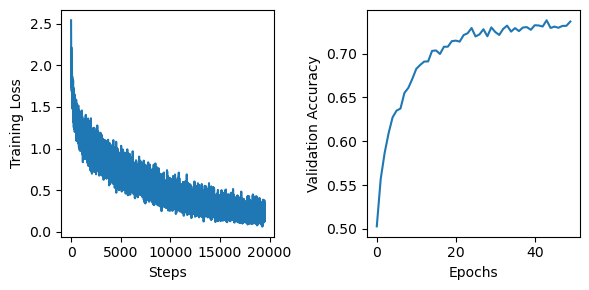

In [39]:
transforms_val = T.Compose([
    T.ToTensor(),
    T.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])
transforms_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.ToTensor(),
    T.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

model = VisionTransformer().to(device)
optim = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()


dataloader_train = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=True, download=True, transform=transforms_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
dataloader_val = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=False, download=True, transform=transforms_val), batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

train_losses = []
val_accs = []

for i_epoch in range(N_EPOCHS):
    for i_step, (images, labels) in (pbar := tqdm(enumerate(dataloader_train), desc=f'Training (Epoch {i_epoch + 1}/{N_EPOCHS})')):
        optim.zero_grad()
        loss = loss_fn(model(images.to(device)), labels.to(device))
        loss.backward()
        optim.step()

        # Some logging
        loss_val = loss.detach().item()
        train_losses.append(loss_val)
        pbar.set_postfix({ 'loss': loss_val } | ({ 'val_acc': val_accs[-1] } if len(val_accs) > 0 else { }))
    
    # Validation every epoch
    with torch.no_grad():
        n_total, n_correct = 0, 0
        for i_step, (images, labels) in (pbar := tqdm(enumerate(dataloader_val), desc='Validating')):
            predicted = model(images.to(device)).argmax(dim=-1)
            n_correct += (predicted.cpu() == labels).float().sum().item()
            n_total += labels.shape[0]
        val_accs.append(n_correct / n_total)
        print(f'Validation accuracy: {val_accs[-1]:.3f}')

plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.plot(train_losses)
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.subplot(122)
plt.plot(val_accs)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.tight_layout()
plt.show()